# Encoding and Decoding 
## COGS 138 - Final Project
#### Tayler Shaw, Aliya Paracha, Aaron Smith, Andrew Hernandez

In [243]:
#!pip install neurodsp

In [244]:
# Import burst detection functions
from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats

# Import simulation code for creating test data
from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed, create_times

# Import utilities for loading and plotting data
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.time_series import plot_time_series, plot_bursts

In [245]:
import h5py
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
from h5py import Group

from neurodsp.plts import plot_time_series
from neurodsp.filt import filter_signal
import numpy as np

from sklearn.model_selection import train_test_split
# the paper uses 1024 trees, & the size of the feature set considered for each 
# split is 1,2,4,5,8,12,16, & 20. 
from sklearn.ensemble import RandomForestClassifier

# Import library for our grid search
from sklearn.model_selection import GridSearchCV
#Import library for evalating the model 
from sklearn import metrics

## Goals for this Project:

Perform basic neutral vs. aversive stimulus analyses:

    OBJECTIVES:

    Event-related LFP potentials
    LFP spectra for neutral vs. aversive, event-related changes in spike rates, etc.
    Perform classification of stimulus type based on neural features
    Test Classifier on Test Set 

## Background Information & Helpful Links


###### Infomation on Modeling
Holdgraf & et al. paper.  

https://www.frontiersin.org/articles/10.3389/fnsys.2017.00061/full

###### Potential Model
This paper is a potential model for what we want to replicate

https://arxiv.org/ftp/arxiv/papers/1903/1903.07272.pdf

###### Dataset Background Information

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7809031/

##### Download the dataset 

G-node.org:

https://doi.gin.g-node.org/10.12751/g-node.270z59/

Personal Google Drive:

https://drive.google.com/drive/folders/1YSRA4gXxbHIzbIhokkzNPwBltfAgaH2f?usp=sharing

## SUBJECTS 

#### Description
We present an electrophysiological dataset collected from the amygdalae of nine subjects attending a visual dynamic stimulation of emotional aversive content. The subjects were patients affected by epilepsy who underwent preoperative invasive monitoring in the mesial temporal lobe. Subjects were presented with dynamic visual sequences of fearful faces (aversive condition), interleaved with sequences of neutral landscapes (neutral condition). The dataset contains the simultaneous recording of intracranial EEG (iEEG) and neuronal spike times and waveforms, and localization information for iEEG electrodes. Subject characteristics and trial information are provided. We technically validated this dataset and provide here the spike sorting quality metrics and the spectra of iEEG signals. This dataset allows the investigation of amygdalar response to dynamic aversive stimuli at multiple spatial scales, from the macroscopic EEG to the neuronal firing in the human brain.

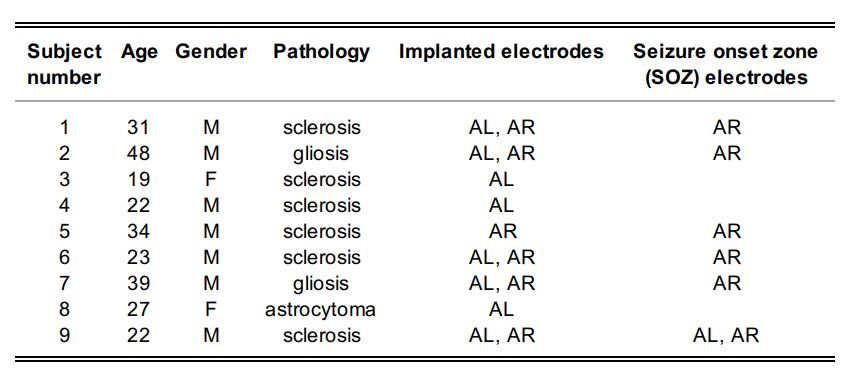

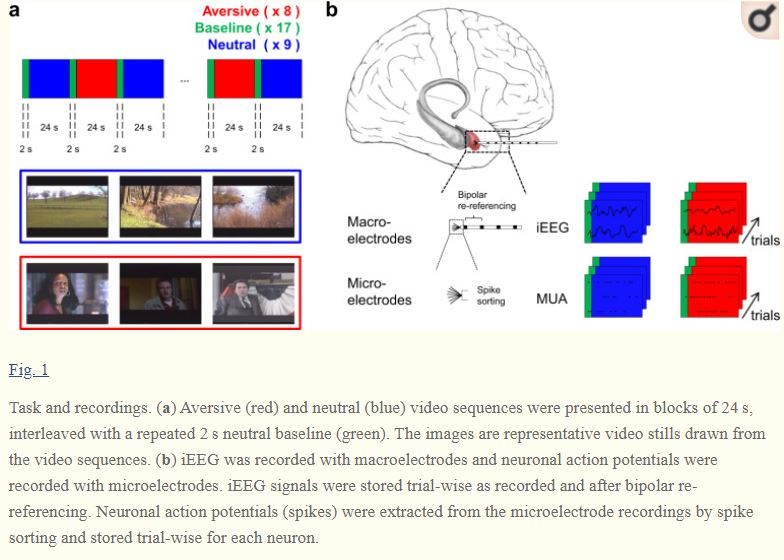

fig1 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7809031/)

In [246]:
# create an Empty DataFrame object 
data = pd.DataFrame() 
subject_Age = [31,48,19,22,34,23,39,27,22]
subject_Gender = [1,1,0,1,1,1,1,0,1]
subject_Electrodes = [['AL','AR'],['AL','AR'],['AL'],['AL'],['AR'],['AL','AR'],['AL','AR'],['AL'],['AL','AR']]
subject_Pathology = ['sclerosis','gliosis','sclerosis','sclerosis','sclerosis','sclerosis','gliosis','astrocytoma','sclerosis']
subject_siezureZone = [['AR'],['AR'],['none'],['none'],['AR'],['AR'],['AR'],['none'],['AL','AR']]
data["Age"] = subject_Age
data["Gender"] = subject_Gender
data["Pathology"] = subject_Pathology
data["Implanted Electrodes"] = subject_Electrodes
data["Siezure Onset Zone"] = subject_siezureZone
data

,Age,Gender,Pathology,Implanted Electrodes,Siezure Onset Zone
0,31,1,sclerosis,"[AL, AR]",[AR]
1,48,1,gliosis,"[AL, AR]",[AR]
2,19,0,sclerosis,[AL],[none]
3,22,1,sclerosis,[AL],[none]
4,34,1,sclerosis,[AR],[AR]
5,23,1,sclerosis,"[AL, AR]",[AR]
6,39,1,gliosis,"[AL, AR]",[AR]
7,27,0,astrocytoma,[AL],[none]
8,22,1,sclerosis,"[AL, AR]","[AL, AR]"


##### Recordings

Sampling frequency of 4 kHz for the macroelectrodes and 32 kHz for the microelectrodes via the ATLAS recording system (0.5–5000 Hz

 iEEG data were resampled at 2 kHz.” In the presented dataset, we share epoched iEEG data (trials of 26 seconds)

In [247]:
fs_macroelectrodes = 4*1000
fs_microelectrodes = 32*1000
fs_iEEG = 2*1000
dt = 26

##### Spike detection and neuron identification

Combinato follows a similar procedure to other freely available software packages: peak detection in the high-pass (>300 Hz) signal, computation of wavelet coefficients for detected peaks, and superparamagnetic clustering in the feature space of wavelet coefficients. As an advantage over other clustering procedures, Combinato is more sensitive in the detection of clusters of small size (few action potentials). 

###### Steps:

    * Visually inspected each identified cluster based on the shape and amplitude of the action potentials and the interspike interval (ISI) distributions.

    * Removed clusters noisy waveforms, or nonuniform amplitude or shape of the action potentials in the recorded time interval.

    * Avoid overclustering, by merging highly similar clusters identified on the same microelectrode to obtain units. 
        Considered only units with firing rate >1 Hz. Finally, we computed several metrics of spike sorting quality

Combinato Package 
https://github.com/jniediek/combinato

#### More Information

For more information on the subject data see this google drive here 

Google Drive
https://drive.google.com/drive/folders/1FW1eMtkcOpRsE3Pk_5svNhImD_yj2g7_?usp=sharing

In [248]:
data_dir = "./data_NIX/"

### Helper Function to unpack the data from the H5 file

In [249]:
def unpack_data(h5):

    h5 = h5py.File(h5, 'r')

    data_dict = {}

    subj = list(h5['data'].keys())[0]
    data_arrays = h5['data'][subj]['data_arrays']

    for key in data_arrays.keys():

            if isinstance(data_arrays[key]['data'], h5py._hl.dataset.Dataset):

                data_dict[key] =  np.array(data_arrays[key]['data'])

    return data_dict

##### This is all of the metadata for each subject now unpacked

In [250]:
subject1 = unpack_data('data_NIX/Data_Subject_01_Session_01.h5')
subject2 = unpack_data('data_NIX/Data_Subject_02_Session_01.h5')
subject3 = unpack_data('data_NIX/Data_Subject_03_Session_01.h5')
subject4 = unpack_data('data_NIX/Data_Subject_04_Session_01.h5')
subject5 = unpack_data('data_NIX/Data_Subject_05_Session_01.h5')
subject6 = unpack_data('data_NIX/Data_Subject_06_Session_01.h5')
subject7 = unpack_data('data_NIX/Data_Subject_07_Session_01.h5')
subject8 = unpack_data('data_NIX/Data_Subject_08_Session_01.h5')
subject9 = unpack_data('data_NIX/Data_Subject_09_Session_01.h5')

### Helper Functions 

I created these helper functions to extract certain information that I may have wanted to use for analysis of the data.

In [251]:
# This give you the list of the ket from the subject data
def key_list(subject_data):
    key_list = list(subject_data.keys())
    return key_list

In [252]:
# key_list(subject1)

In [253]:
def get_key(subject_data,key_index):
    keys_list = list(subject_data)
    key = keys_list[key_index]
    return key    

In [254]:
#get_key(subject1,0)

In [255]:
# Helper function returns list data by index keys
def get_data(subject_data,key_index):
    keys_list = list(subject_data)
    key = keys_list[key_index]
    data = list(subject_data[key])
    return data

In [256]:
#get_data(subject1,0)

In [257]:
def create_df(subject_data,key_index):
    key = get_key(subject_data,key_index)
    data = get_data(subject_data,key_index)
    df = pd.DataFrame(data,columns = [key])
    return df

In [258]:
#create_df(subject1,0)

In [259]:
# All of the data for every subject data have the iEEG data, this creates a dataframes of that data when called 
def get_df(subject_data,start,num_trials):
    df = pd.DataFrame()
    j = start
    for i in range(num_trials):    
        df[get_key(subject_data,j)] = get_data(subject_data,j)
        j += 1
    return df

In [260]:
#get_df(subject1,0,17)

In [261]:
# For each subject there is a different number of trials, the pattern of how the stimulus was shown was always
# presented in this way. This function creates a list of trials to help with later seperating neutral versus aversive

def neutral_aversive(units):
    n = 1
    a = 0
    list_stimulus_types = [n,a,n,a,n,a,n,a,n,a,n,a,n,a,n,a,n]*units
    return list_stimulus_types

In [262]:
# For instance subject 1 has 17 trials of 4 units, therefor this is the list to distinguish all the aversive and neutral 

#neutral_aversive(4)

Checking the length of the key list inside each subject to see how they compare

In [263]:
# Here I just wanted to see the length of the keys in each subject 
size1 = len(key_list(subject1))
size2 = len(key_list(subject2))
size3 = len(key_list(subject3))
size4 = len(key_list(subject4))
size5 = len(key_list(subject5))
size6 = len(key_list(subject6))
size7 = len(key_list(subject7))
size8 = len(key_list(subject8))
size9 = len(key_list(subject9))
sizes = [size1,size2,size3,size4,size5,size6,size7,size8,size9]
print(sizes)

[91, 235, 73, 145, 19, 19, 307, 19, 19]


So now its obvious that this data is not consistent across the different subjects so now I want to look through each subject and see which one actually have the full dataset that we can you to do further analysis. 

## Contents of Data

Here I just wanted to explore the data, so that I could get an idea  of what we can use for the analysis. I wanted to know what was missing and what was the same from each subject and which subjects might be better for which types of analysis. 

In [264]:
#Subject 1 data has, number of dict keys 91
#17 iEEG Data Trials              get_key(subject1,0) -> get_key(subject1,16)
# Spike Times -------
#17 uAL-1 Trials                  get_key(subject1,17) -> get_key(subject1,33)
#17 uAL-2 trials                  get_key(subject1,34) -> get_key(subject1,50)
#17 uAL-6 trials                  get_key(subject1,51) -> get_key(subject1,67)
#17 uAR-7 trials                  get_key(subject1,68) -> get_key(subject1,84)
# -------------------
#'Spike_Waveform_Unit_1_uAL_1'    get_key(subject1,85)
#'Spike_Waveform_Unit_2_uAL_2'    get_key(subject1,86)
#'Spike_Waveform_Unit_3_uAL_6'    get_key(subject1,87)
#'Spike_Waveform_Unit_4_uAR_7'    get_key(subject1,88)

#'iEEG_Electrode_Map'             get_key(subject1,89)
#'iEEG_Electrode_MNI_Coordinates  get_key(subject1,90)

#Uncomment to see the full list here
#key_list(subject1) 

### iEEG Data



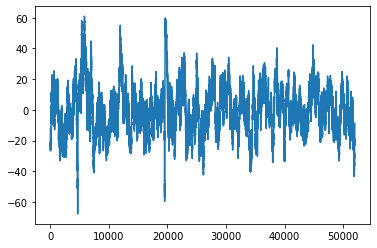

In [265]:
# PLot the iEEG Data 
plt.plot(subject1['iEEG_Data_Trial_01'][0])


### Exploring the Trials

In [266]:
#All of the Trial Data are time stamps of when the spike times occured, 
# starting at -2 seconds [baseline ]and going up to nearly 24 seconds[stimulus time], 

#This is the data for 'Spike_Times_Unit_1_uAL_1_Trial_16'
subject1[get_key(subject1,32)]

array([-0.41282   , -0.4051325 , -0.26216375,  0.04602375,  0.20864875,
        0.220055  ,  1.3064925 ,  4.51502175,  5.033678  ,  5.04033425,
        5.049053  ,  5.40839675,  6.95608325,  6.974427  ,  8.3137395 ,
       10.08183225, 10.75064475, 10.7563635 , 13.51958125, 13.52489375,
       16.521299  , 19.970422  , 20.94870325, 20.95576575])

In [267]:
#This calculates when the spike time ended for each trial

#This creates a list of all the last time stamps from every trial
time_samples_end = []
for i in range(67):
    time_samples_end.append(subject1[get_key(subject1,17+i)][-1])

#See when all the trials ended
print("The average last time when spike occured = ",np.mean(time_samples_end))

The average last time when spike occured =  22.89753258955178


In [268]:
# How many last spike times were less than 22 seconds

#This looks at how many time counts were less than 22 secs, in this cas there was 11 trials thats went less than 22 sec
values = []
false_time = 0
for i in range(len(time_samples_end)):
    if time_samples_end[i] > 22:
        values.append(True)
    else:
        values.append(False)
        false_time+=1
        
print("The number of last spike time occuring less than 22 seconds = ",false_time)

The number of last spike time occuring less than 22 seconds =  11


In [269]:
# This is the maximum number and the minimim number of spike times in  given trial
time_samples = []
for i in range(67):
    for j in range(len(subject1[get_key(subject1,17+i)])):
        time_samples.append(len(subject1[get_key(subject1,17+i)]))
    
print("Mean # of spikes over all trials = ",np.mean(time_samples))
print("Max # of spikes in a single trial = ",np.max(time_samples))
print("Min # of spikes in a single trial = ",np.min(time_samples))
#time_samples

Mean # of spikes over all trials =  54.38643067846608
Max # of spikes in a single trial =  140
Min # of spikes in a single trial =  8


In [270]:
# Count of total spikes across all trials for both before (base) stimulus and after (stim) 
n_a_list = neutral_aversive(4)
na_list = {'neutral_aversive':n_a_list}
subject1_stim_df = pd.DataFrame(data = na_list)

count_stim = []
count_base = []
#trials * unit 
for j in range(17*4):
    #stim
    count_stim.append(len([i for i in subject1[get_key(subject1,17+j)] if i > 0]))
    #base
    count_base.append(len([i for i in subject1[get_key(subject1,17+j)] if i < 0]))

    
print("The total count in spike times during stimulus = ",sum(count_stim))
print("The total count in spikes times before stimulus = ",sum(count_base))

The total count in spike times during stimulus =  2603
The total count in spikes times before stimulus =  189


In [271]:
# Datafram of spikes times per trial for each unit for both before (base) stimulus and after (stim) 
subject1_stim_df['count_stim'] = count_stim
subject1_stim_df['count_base'] = count_base
stim_count = subject1_stim_df['count_stim'].sum()
base_count = subject1_stim_df['count_base'].sum()
print("The total count in spike times during stimulus = ",stim_count)
print("The total count in spikes times before stimulus = ",base_count)
subject1_stim_df

The total count in spike times during stimulus =  2603
The total count in spikes times before stimulus =  189


,neutral_aversive,count_stim,count_base
0,1,37,10
1,0,9,0
2,1,50,1
3,0,18,4
4,1,50,5
...,...,...,...
63,1,57,3
64,0,64,4
65,1,93,3
66,0,75,2


## Preprocessing the Data 

In [272]:
subject1_stim_df_copy_1 = subject1_stim_df.copy()
subject1_stim_df_copy_1 = subject1_stim_df_copy_1['neutral_aversive']
subject1_an_array = np.array(subject1_stim_df_copy_1)
subject1_stim_df_copy = subject1_stim_df.copy()
subject1_stim_df_copy = subject1_stim_df_copy.drop(['neutral_aversive'], axis=1)
subject1_stim_array = np.array(subject1_stim_df_copy)
# array of [spike_time_stim, spike_time_base] shape = 68x2
print("Size of the inputs: ",np.shape(subject1_stim_array))
print("Size of the targets: ",np.shape(subject1_an_array))

Size of the inputs:  (68, 2)
Size of the targets:  (68,)


In [273]:
from sklearn.model_selection import RepeatedStratifiedKFold
X = subject1_stim_array
y = subject1_an_array

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .9, random_state = 1)
#cross validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3)

## Random Forrest 

In [274]:
#define model 
model = RandomForestClassifier()
#define search space
max_features = [1, 2, 4, 5, 8, 12, 16, 20]
space = dict()
space['n_estimators'] = [1024]
space['criterion'] = ['gini']
space['max_features'] = max_features
#define search:
search = GridSearchCV(model, space, scoring = 'accuracy', n_jobs = -1, cv = cv)
#execute search
result = search.fit(X_train, y_train)



In [275]:
#summarize result for cross validtion
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Estimator: %s' % result.best_estimator_)

Best Score: 0.5615384615384615
Best Hyperparameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 1024}
Best Estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1024,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [276]:
# train on all of training data and use best hyperparameters to evaluate accuracy 
# on test set
optimalmodel = result.best_estimator_
optimalmodel.fit(X_train, y_train)
y_predict = optimalmodel.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_predict)
print('accuracy on test set: %s' % accuracy)

accuracy on test set: 0.7142857142857143


We definded the cross validation using a repeated stratified k folds of the spike times for aversive and neutal stimulus. Then we performs a grid search over a set of parameters in the parameter space. Using a random forest our model obtained an accuracy measure of around 57-59% accuracy. 

## Logistic Regression 


In [229]:
from sklearn.linear_model import LogisticRegression

#define model
model = LogisticRegression()
#define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2']
space['C'] = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
#define search
search = GridSearchCV(model, space, scoring = 'accuracy', n_jobs = -1, cv= cv)
# execute search
result = search.fit(X_train, y_train)
results = search.return_train_score


In [230]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Estimator: %s' % result.best_estimator_)

Best Score: 0.5534188034188035
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Estimator: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


We definded the cross validation using a repeated stratified k folds of the spike times for aversive and neutal stimulus. Then we performs a grid search over a set of parameters in the parameter space. Using a a logistic regression our model obtained an accuracy measure of around 56-58% accuracy. 

In [231]:
# train on all of taining data and use best hyperparameters to evaluate accuracy 
# on test set
optimalmodel = result.best_estimator_
optimalmodel.fit(X_train, y_train)
y_predict = optimalmodel.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_predict)
print('accuracy on test set: %s' % accuracy)

accuracy on test set: 0.8571428571428571


## Counting Spike Times 

In [232]:
# Counting the neutral stimulus spike times
subject1_stim_neutral = subject1_stim_df[subject1_stim_df['neutral_aversive'] == 1]
total_spike_neutral = sum(subject1_stim_neutral["count_stim"])
spike_average_neutral = total_spike_neutral / len(subject1_stim_neutral)
print("Number of Neutral Spikes : ",total_spike_neutral)
print("Number of Neutral Stimulus : ",len(subject1_stim_neutral))
print("Average of Neutral Stimulus per Trial: ",spike_average_neutral)
subject1_stim_neutral.head()

Number of Neutral Spikes :  1464
Number of Neutral Stimulus :  36
Average of Neutral Stimulus per Trial:  40.666666666666664


,neutral_aversive,count_stim,count_base
0,1,37,10
2,1,50,1
4,1,50,5
6,1,41,1
8,1,39,1


In [233]:
# Counting the aversive stimulus spike times
subject1_stim_aversive = subject1_stim_df[subject1_stim_df['neutral_aversive'] == 0]
total_spike_aversive = sum(subject1_stim_aversive["count_stim"])
spike_average_aversive = total_spike_aversive / len(subject1_stim_aversive)
print("Number of Aversive Spikes : " + str(total_spike_aversive))
print("Number of Aversive Stimulus : " + str(len(subject1_stim_aversive)))
print("Average of Aversive Stimulus per Trial: " + str(spike_average_aversive))
subject1_stim_aversive.head()

Number of Aversive Spikes : 1139
Number of Aversive Stimulus : 32
Average of Aversive Stimulus per Trial: 35.59375


,neutral_aversive,count_stim,count_base
1,0,9,0
3,0,18,4
5,0,33,1
7,0,40,4
9,0,47,5


### Exploring the iEEG Data

In [234]:
import scipy
from scipy.fft import fft, fftfreq

fs = fs_iEEG

In [235]:
def bandPassFilter(signal):
    fs = 1000.0
    lowcut = 9.0
    highcut = 20.0
    
    nyq = .5*fs
    low = lowcut / nyq
    high = highcut / nyq
    
    order = 2
    
    b, a = scipy.signal.butter(order,[low,high],'bandpass',analog=False)
    y = scipy.signal.filtfilt(b,a,signal,axis=0)
    return y 

In [236]:
filtered_EEG = bandPassFilter(subject1['iEEG_Data_Trial_01'][0])

In [237]:
def fft_data(data):
    # Number of samples in normalized_tone
    N = len(data)
    yf = fft(data)
    xf = fftfreq(N, 1 / fs)
        
    return xf, yf



def fft_plot(data):
    # Number of samples in normalized_tone
        N = len(data)
        yf = fft(data)
        xf = fftfreq(N, 1 / fs)
        plt.plot(xf, np.abs(yf))
        plt.xlim(0,100)
        plt.show()
        

11.4255
11.4085
565
51330
25999
26000


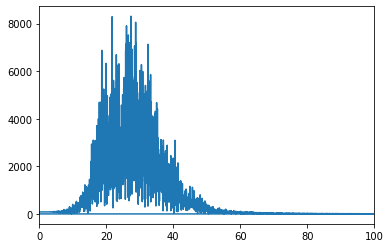

In [238]:
#
xf, yf = fft_data(filtered_EEG)
print(filtered_EEG.argmax()/fs) #11.4255
print(filtered_EEG.argmin()/fs) #11.4085
print(np.argmax(yf)) #565
print(np.argmin(yf)) #51330
print(np.argmax(xf)) #25999
print(np.argmin(xf)) #26000
fft_plot(filtered_EEG)


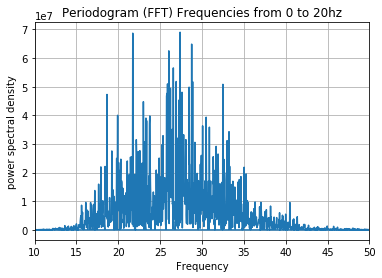

In [165]:
#Periodogram (FFT) Frequencies from 0 to 50hz
power = np.abs(np.fft.fft(filtered_EEG))**2
frequency = np.fft.fftfreq(len(filtered_EEG),1/fs)
plt.plot(frequency,power)
plt.xlabel('Frequency')
plt.ylabel("power spectral density")
plt.title("Periodogram (FFT) Frequencies from 0 to 50hz")
plt.xlim(10,50)
plt.grid()

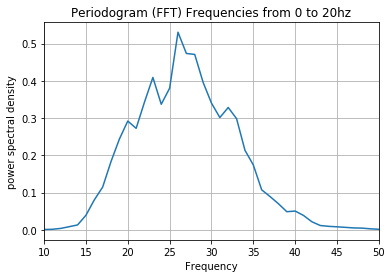

In [239]:
# Periodogram (FFT) Frequencies from 0 to 20hz
f, pxx = scipy.signal.welch(filtered_EEG, fs = fs, scaling = 'spectrum', nperseg = 2000)
plt.plot(f,pxx)
plt.xlabel('Frequency')
plt.ylabel("power spectral density")
plt.title("Periodogram (FFT) Frequencies from 0 to 20hz")
plt.xlim(10,50)
plt.grid()

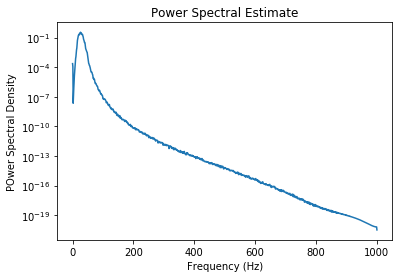

In [242]:
# Power Spectral Estimate
f, pxx = scipy.signal.welch(filtered_EEG, fs = fs, nperseg = 2000)
plt.semilogy(f,pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel("POwer Spectral Density")
plt.title("Power Spectral Estimate")

import warnings
warnings.filterwarnings("ignore")

### Plot Spike_Waveform_Unit_1

Inside this data there are two waveforms, ,the second one seems to be the raw spike waveform and the first one seems to be and averages, smoothed out version of the spike form. This is consistent with all Spike Waveform data. 

#### Spike_Waveform_Unit_1_uAL_1

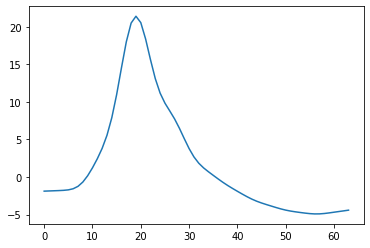

In [168]:
#Smooth Waveform
Spike_Waveform_Unit_1_uAL_1_a = subject1[get_key(subject1,85)][0]
plt.plot(Spike_Waveform_Unit_1_uAL_1_a)

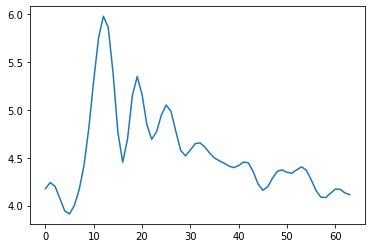

In [169]:
#Raw Waveform 
Spike_Waveform_Unit_1_uAL_1_b = subject1[get_key(subject1,85)][1]
plt.plot(Spike_Waveform_Unit_1_uAL_1_b)

#### Spike_Waveform_Unit_2_uAL_2
Uncomment to see the Spike WaveForms

In [180]:
#plt.plot(subject1[get_key(subject1,86)][0])

In [181]:
#plt.plot(subject1[get_key(subject1,86)][1])

#### Spike_Waveform_Unit_3_uAL_6

In [182]:
#plt.plot(subject1[get_key(subject1,87)][0])

In [183]:
#plt.plot(subject1[get_key(subject1,87)][1])

#### Spike_Waveform_Unit_4_uAL_7

In [71]:
#plt.plot(subject1[get_key(subject1,88)][0])

In [72]:
# plt.plot(subject1[get_key(subject1,88)][1])

#### iEEG_Electrode_Map

In [184]:
subject1[get_key(subject1,89)]

array([1, 2], dtype=uint16)

#### iEEG_Electrode_MNI_Coordinates

In [185]:
subject1[get_key(subject1,90)][0]

array([-25.16,  -0.06, -19.27])

In [186]:
subject1[get_key(subject1,90)][1]

array([ 22.01,  -3.91, -24.98])

## Data for other Subjects

### Organization of Data For All Subjects

In [188]:
#Subject 2 data has, number of dict keys 235

#17 iEEG Data Trials
#Spike Times----------
#17 Unit 1 uAL-5 Trials
#17 Unit 2 uAL-8 trials
#17 Unit 3 uAR-1 trials
#17 unit 4 uAR-1 trials
#17 unit 5 uAR-2 trials
#17 unit 6 uAR-3 trials
#17 unit 7 uAR-4 trials
#17 unit 8 uAR-5 trials
#17 unit 9 uAR-6 trials
#17 unit10 uAR-7 trials
#17 unit11 uAR-8 trials
#17 unit12 uAL-8 trials
#----------------------
# 'Spike_Waveform_Unit_1_uAL_5',
# 'Spike_Waveform_Unit_2_uAL_8',
# 'Spike_Waveform_Unit_3_uAR_1',
# 'Spike_Waveform_Unit_4_uAR_1',
# 'Spike_Waveform_Unit_5_uAR_2',
# 'Spike_Waveform_Unit_6_uAR_3',
# 'Spike_Waveform_Unit_7_uAR_4',
# 'Spike_Waveform_Unit_8_uAR_5',
# 'Spike_Waveform_Unit_9_uAR_6',
# 'Spike_Waveform_Unit_10_uAR_7',
# 'Spike_Waveform_Unit_11_uAR_8',
# 'Spike_Waveform_Unit_12_uAL_8',
#'iEEG_Electrode_Map'
#'iEEG_Electrode_MNI_Coordinates

#Uncomment to see the full list here
#key_list(subject2) 

In [189]:
#Subject 3 data has, number of dict keys 73

#17 iEEG Data Trials
#Spike Times----------
#17 Unit_1_uAL_2 Trials
#17 Unit_2_uAL_5 Trials
#17 Unit_3_uAL_3
#17 Unit_2_uAL_5
#----------------------
#'Spike_Waveform_Unit_1_uAL_2',
# 'Spike_Waveform_Unit_2_uAL_5',
# 'Spike_Waveform_Unit_3_uAL_3',
# 'iEEG_Electrode_Map',
# 'iEEG_Electrode_MNI_Coordinates',

#Uncomment to see the full list here
#key_list(subject3) 

In [190]:
#Subject 4 data has,  number of dict keys 145

#17 iEEG Data Trials
#Spike Times----------
#17 Unit_1_uAL_1_Trials
#17 Unit_2_uAL_2_Trials
#17 Unit_3_uAL_2_Trials
#17 Unit_4_uAL_3_Trial
#17 Unit_5_uAL_4_Trial
#17 Unit_6_uAL_6_Trial
#17 Unit_7_uAL_7_Trial
#----------------------
# 'Spike_Waveform_Unit_1_uAL_1',
# 'Spike_Waveform_Unit_2_uAL_2',
# 'Spike_Waveform_Unit_3_uAL_2',
#  'Spike_Waveform_Unit_4_uAL_3',
#  'Spike_Waveform_Unit_5_uAL_4',
#  'Spike_Waveform_Unit_6_uAL_6',
#  'Spike_Waveform_Unit_7_uAL_7',
#  'iEEG_Electrode_Map',
#  'iEEG_Electrode_MNI_Coordinates'

#Uncomment to see the full list here
#key_list(subject4) 

Skipping over 5 and 6 because the subjects have no spike times, they are grouped with 8 and 9. (Since they have similar data layouts)

In [191]:
#Subject 7 data has, number of dict keys 307

#17 iEEG Data Trials
#Spike Times----------
#17 Unit_1_uAL_1_Trial
#17 Unit_2_uAL_1_Trials
#17 Unit_3_uAL_2_Trial
#17 Unit_4_uAL_4_Trials
#17 Unit_5_uAL_5_Trials
#17 Unit_6_uAL_5_Trials
#17 Unit_7_uAL_6_Trials
#17 Unit_8_uAL_7_Trials
#17 Unit_9_uAL_8_Trials
#17 Unit_10_uAR_1_Trials
#17 Unit_11_uAR_2_Trials
#17 Unit_12_uAR_3_Trials
#17 Unit_13_uAR_5_Trials
#17 Unit_14_uAR_6_Trials
#17 Unit_15_uAR_7_Trials
#17 Unit_16_uAR_8_Trials
#----------------------
# 'Spike_Waveform_Unit_1_uAL_1',
# 'Spike_Waveform_Unit_2_uAL_1',
# 'Spike_Waveform_Unit_3_uAL_2',
# 'Spike_Waveform_Unit_4_uAL_4',
# 'Spike_Waveform_Unit_5_uAL_5',
# 'Spike_Waveform_Unit_6_uAL_5',
# 'Spike_Waveform_Unit_7_uAL_6',
# 'Spike_Waveform_Unit_8_uAL_7',
# 'Spike_Waveform_Unit_9_uAL_8',
# 'Spike_Waveform_Unit_10_uAR_1',
# 'Spike_Waveform_Unit_11_uAR_2',
# 'Spike_Waveform_Unit_12_uAR_3',
# 'Spike_Waveform_Unit_13_uAR_5',
# 'Spike_Waveform_Unit_14_uAR_6',
#  'Spike_Waveform_Unit_15_uAR_7',
#  'Spike_Waveform_Unit_16_uAR_8',
#  'iEEG_Electrode_Map',
#  'iEEG_Electrode_MNI_Coordinates'

#Uncomment to see the full list here
#key_list(subject7) 

In [192]:
#Subject 5, AND 6, AND 8, AND 9  data has, number of dict keys 19 for each

#17 iEEG Data Trials
#Spike Times----------
# NONE !!!
#  'iEEG_Electrode_Map',
#  'iEEG_Electrode_MNI_Coordinates'

#Uncomment to see the full list here
#key_list(subject5) 
#key_list(subject6)
#key_list(subject8)
#key_list(subject9)

Conclusions about the data.

For every subject, if they did have spike time data then they also had the spike waveform data for each of the trials. For every subject the amount of units they had for AL or AR were different for each  subject so here is a summary of their differences.

                    #uAL           #UAR
    subject1          3              1
    subject2          3              9
    subject3          4              0
    subject4          7              0 
    subject7          9              8

    subject5          0              0
    subject6          0              0
    subject8          0              0
    subject9          0              0

Looking at this data, we have data for AL across all the subects, and AR data for only subject1, subject2, and subject8.
It seems that subject 7 has the most data and may be the best for looking at comparisons between AL and AR. 

Going forward I will focus the majority of my analysis on subject7, and completely drop all the data from subjects 5,6,8, and 9.

### Helper Function Creates iEEG Dataframes for All Sujects

In [197]:
# iEEG Data for all Subjects
subject1_iEEG_Data = get_df(subject1,0,17)
subject2_iEEG_Data = get_df(subject2,0,17)
subject3_iEEG_Data = get_df(subject3,0,17)
subject4_iEEG_Data = get_df(subject4,0,17)
subject5_iEEG_Data = get_df(subject5,0,17)
subject6_iEEG_Data = get_df(subject6,0,17)
subject7_iEEG_Data = get_df(subject7,0,17)
subject8_iEEG_Data = get_df(subject8,0,17)
subject9_iEEG_Data = get_df(subject9,0,17)


In [228]:
# Here is the dataframe of the iEEG Data of all 17 trials 
subject1_iEEG_Data[get_key(subject9,0,17)]

NameError: name 'subject1_iEEG_Data' is not defined

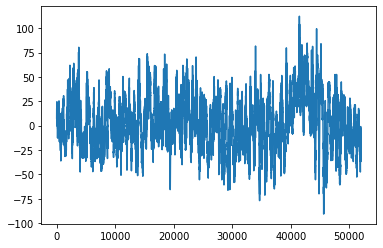

In [203]:
#Here I just want to explore what a single trial of the iEEG data looks like plotted
iEEG_data = subject9_iEEG_Data['iEEG_Data_Trial_01'][0]
iEEG_data = list(iEEG_data)

plt.plot(iEEG_data)

In [213]:
len(iEEG_data)/fs_iEEG

26.0

In [209]:
# Compute burst statistics
burst_stats = compute_burst_stats(iEEG_data, 1000)

# # Print out burst statistic information
# for key, val in burst_stats.items():
#     print('{:15} \t: {}'.format(key, val))
burst_stats

ValueError: operands could not be broadcast together with shapes (25999,) (26000,) 

In [225]:
# Spike Times for subjects 1,2,3,4,7
# There is issues with createing a helper function with this because all the spike times have different lengths of values. 

SUBJECT 1

In [ ]:
#Subject 1 data has, number of dict keys 91
#17 iEEG Data Trials
# Spike Times -------
#17 uAL-1 Trials                  get_key(subject1,17) -> get_key(subject1,33)
#17 uAL-2 trials                  get_key(subject1,34) -> get_key(subject1,50)
#17 uAL-6 trials                  get_key(subject1,51) -> get_key(subject1,67)
#17 uAR-7 trials                  get_key(subject1,68) -> get_key(subject1,84)
# -------------------
#'Spike_Waveform_Unit_1_uAL_1'    get_key(subject1,85)
#'Spike_Waveform_Unit_2_uAL_2'    get_key(subject1,87)
#'Spike_Waveform_Unit_3_uAL_6'    get_key(subject1,88)
#'Spike_Waveform_Unit_4_uAR_7'    get_key(subject1,89)

#'iEEG_Electrode_Map'             get_key(subject1,90)
#'iEEG_Electrode_MNI_Coordinates  get_key(subject1,91)

#Uncomment to see the full list here
#key_list(subject1) 

In [267]:
s = get_data(subject1,85)
s

[array([-1.88311148, -1.85782933, -1.83391523, -1.80895185, -1.77613604,
        -1.71311462, -1.56476033, -1.24511707, -0.67524636,  0.16444212,
         1.22039437,  2.42662573,  3.81003261,  5.54832125,  7.89359999,
        10.96527195, 14.5365181 , 17.98507309, 20.48991203, 21.39605141,
        20.54595757, 18.36421013, 15.63095284, 13.09558773, 11.1667738 ,
         9.82936287,  8.78939438,  7.72407579,  6.47695494,  5.10383749,
         3.78248811,  2.67478633,  1.83571506,  1.21092606,  0.69888926,
         0.21994203, -0.25306994, -0.70930755, -1.1335001 , -1.52679121,
        -1.90286183, -2.27096772, -2.62501788, -2.94790459, -3.22588038,
        -3.46046567, -3.66799831, -3.86691761, -4.06351948, -4.24863291,
        -4.40764236, -4.53414249, -4.63509226, -4.72361994, -4.80619717,
        -4.87523985, -4.91367102, -4.90778208, -4.85776901, -4.77778959,
        -4.68639326, -4.59553003, -4.50647449, -4.41448355]),
 array([4.17640924, 4.24069071, 4.19941664, 4.07334518, 3.9436

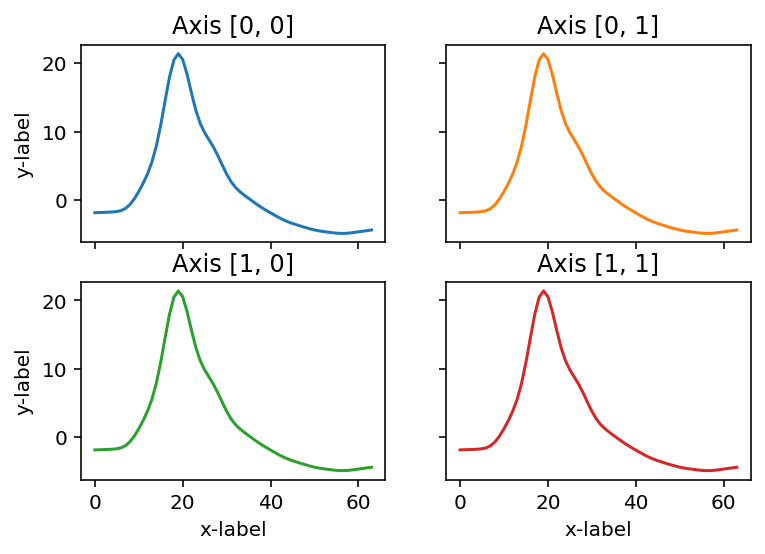

In [262]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(s[0])
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(s[0], 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(s[0], 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(s[0], 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
get_data(subject1,17)

In [ ]:
get_data(subject1,17)

In [150]:
def stimulus_order(h5):

    h5 = h5py.File(h5, 'r')

    subj_key = list(h5['data'].keys())[0]
    labels = list(h5['data'][subj_key]['tags'].keys())
    labels = [label for label in labels if label.endswith('Spike_Times')]

    stim_order = [label[21:-21].lower() for label in labels]

    return stim_order

In [206]:
# Looking at the stimulus order, it follows a pattern os starting neutral 
# and interchanging from neutral to aversive for all 17 trials

stim_order = stimulus_order('data_NIX/Data_Subject_01_Session_01.h5')
print(len(stim_order))
stim_order[:5]

NameError: name 'stimulus_order' is not defined

### Event Related Potentials

Following the tutorial found on this github account from voytek research  I will attempt to finde the event related potential from the spike times. 

https://github.com/voytekresearch/Tutorials/blob/master/Event%20Related%20Potential%20Tutorial.ipynb

In [162]:
#helpful settings
%config InlineBackend.figure_format = 'retina'
%pylab inline

#Loading all of the helpful modules
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import scipy.io
import scipy.signal

Populating the interactive namespace from numpy and matplotlib


In [ ]:
srate = 
num_samples = 

### AARONS WORK

In [165]:
# def find_base(spike_times):
#     num_neg = 0
#     for x in spike_times:
#         if x < 0:
#             num_neg += 1
#     num_neg
#     base_fire_rate = num_neg / 2
#     return base_fire_rate

In [156]:
# spike_time_bases = []
# #count = 0

# for str1 in spike_time_list:
#     #count += 1
    
#     spike_time_bases.append(find_base(a[0][str1]))
    
# #count
# #'Spike_Times_Unit_2_uAL_2_Trial_01'

# #spike_time_bases

In [157]:
# num_pos = 0

# def find_stim_rate(spike_times):
#     num_pos = 0
#     for x in spike_times:
#         if x >= 0:
#             num_pos += 1
#     num_pos
#     stim_fire_rate = num_pos / 24
#     return stim_fire_rate


In [158]:
# spike_time_stim = []
# #count = 0

# for str1 in spike_time_list:
#     #count += 1
    
#     spike_time_stim.append(find_stim_rate(a[0][str1]))
    

In [159]:
# #stim_type_n = []

# spike_time_bases[0] / spike_time_stim[0]
# spike_time_bases[1] / spike_time_stim[1]

# base_over_stim = []
# count = 0
# for str1 in spike_time_list:
#     #base_comp_stim.append(str1)
    
#     base_over_stim.append(spike_time_bases[count] / spike_time_stim[count])
#     count += 1
    


In [160]:
# base_over_stim[0]

# neutral_index = [0, 2, 4, 6, 8, 10, 12, 14, 16, 17, 19, 21, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 48, 50, 51, 53, 55, 57, 59, 61, 63, 65, 67]
# neutral_base_over_stim = []

# for x in neutral_index:
#     neutral_base_over_stim.append(base_over_stim[x])
    
# neutral_base_over_stim  
    
# aversive_index = [1, 3, 5, 7, 9, 11, 13, 15, 18, 20, 22, 24, 26, 28, 30, 32, 35, 37, 39, 41, 43, 45, 47, 49, 52, 54, 56, 58, 60, 62, 64, 66]
# aversive_base_over_stim = []

# for x in aversive_index:
#     aversive_base_over_stim.append(base_over_stim[x])
    
# print(len(aversive_base_over_stim), len(neutral_base_over_stim))

# #print(aversive_base_over_stim)
# #print(neutral_base_over_stim)
# #aver_prop2_neut = [aversive_base_over_stim, neutral_base_over_stim]
# #aver_prop2_neut

# sum(aversive_base_over_stim) / len(aversive_base_over_stim),  sum(neutral_base_over_stim) / len(neutral_base_over_stim)

# # 0 - 1 is base rate < stim rate
# # 1 - ... is base rate > stim rate


# #sum(neutral_base_over_stim) / sum(aversive_base_over_stim)

In [161]:
# spike_time_list[67]

### Simuluate a Bursty Oscillation

In [18]:
# Set the random seed, for consistency simulating data
set_random_seed(0)

In [19]:
# Simulation settings
fs = 1000
n_seconds = 5

# Define simulation components
components = {'sim_synaptic_current' : {'n_neurons':1000, 'firing_rate':2,
                                        't_ker':1.0, 'tau_r':0.002, 'tau_d':0.02},
              'sim_bursty_oscillation' : {'freq' : 10, 'enter_burst' : .2, 'leave_burst' : .2}}

# Simulate a signal with a bursty oscillation with an aperiodic component & a time vector
sig = sim_combined(n_seconds, fs, components)
times = create_times(n_seconds, fs)

In [20]:
fs = 1000
n_seconds = 5

# Define simulation components
components = {'sim_synaptic_current' : {'n_neurons':1000, 'firing_rate':2,
                                        't_ker':1.0, 'tau_r':0.002, 'tau_d':0.02},
              'sim_bursty_oscillation' : {'freq' : 10, 'enter_burst' : .2, 'leave_burst' : .2}}

# Simulate a signal with a bursty oscillation with an aperiodic component & a time vector
sig = sim_combined(n_seconds, fs, components)
times = create_times(n_seconds, fs)

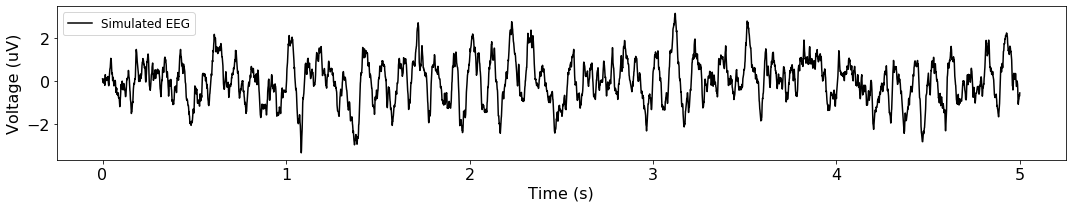

In [21]:
# Plot the simulated data
plot_time_series(times, sig, 'Simulated EEG')

### Dual Amplitude Threshold Algorithm
First, let’s use the dual-amplitude threshold algorithm for burst detection, which we can use with the detect_bursts_dual_threshold() function.

This algorithm first computes the amplitude at each point in time for a given frequency range. This amplitude is then normalized by the average (default: median) amplitude of the whole time series. Two thresholds are defined based off of this normalized amplitude. In order for a burst to be detected, the amplitude must cross the higher amplitude threshold. The burst lasts until the amplitude then falls below the lower amplitude threshold.

Other Parameters

avg_type: used to set the average for normalization to either ‘median’ or ‘mean’

magnitude_type: used to set the metric for thresholding, to ‘amplitude’ or ‘power’

In [22]:
# Settings for the dual threshold algorithm
amp_dual_thresh = (1, 2)
f_range = (8, 12)

# Detect bursts using dual threshold algorithm
bursting = detect_bursts_dual_threshold(sig, fs, amp_dual_thresh, f_range)

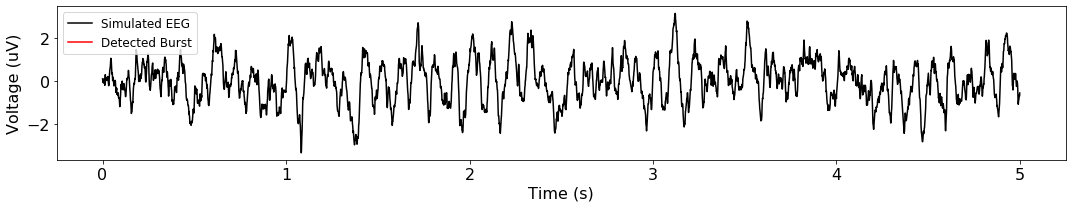

In [23]:
# Plot original signal and burst activity
plot_bursts(times, sig, bursting, labels=['Simulated EEG', 'Detected Burst'])

The graph above shows the bursting activity in red.

The algorithm was used with thresh=(1, 2), so any time point with more than 3 times the median magnitude in the alpha range (8-12 Hz) was marked as bursting activity.

### Checking Burst Statistics
Once you have detected bursts, you can calculate some statistics on those bursts with detect_bursts_dual_threshold().

In [24]:
# Compute burst statistics
burst_stats = compute_burst_stats(bursting, fs)

# Print out burst statistic information
for key, val in burst_stats.items():
    print('{:15} \t: {}'.format(key, val))

n_bursts        	: 0
duration_mean   	: nan
duration_std    	: nan
percent_burst   	: 0.0
bursts_per_second 	: 0.0


C:\Users\17606\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\17606\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\17606\anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\17606\anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\17606\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Download, if needed, and load example data file
sig = load_ndsp_data('sample_data_1.npy', folder='data')
sig = 
# Set sampling rate, and create a times vector for plotting
fs = 1000
times = create_times(len(sig)/fs, fs)